In [1]:
import pertpy as pt
import scanpy as sc
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Augur

## Augur Runtime & Memory

In [66]:
# colname	type (unit)	description
# s	float (seconds)	Running time in seconds
# h:m:s	string (-)	Running time in hour, minutes, seconds format
# max_rss	float (MB)	Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.
# max_vms	float (MB)	Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process
# max_uss	float (MB)	“Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.
# max_pss	float (MB)	“Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only)
# io_in	float (MB)	the number of MB read (cumulative).
# io_out	float (MB)	the number of MB written (cumulative).
# mean_load	float (-)	CPU usage over time, divided by the total running time (first row)
# cpu_time	float(-)	CPU time summed for user and system

In [71]:
dats = {}
for file in Path('snakemake/benchmarks/').rglob('augur.*.pertpy.*'):
    data = pd.read_csv(file, sep='\t')
    n_obs = int(file.stem.split('.')[1])
    if n_obs != 0:
        dats[n_obs] = data
    else:
        dats[600] = data
df = pd.concat(dats)
df.index = df.index.droplevel(1)
df.sort_index(inplace=True)

dats = {}
for file in Path('snakemake/benchmarks/').rglob('augur.*.original.*'):
    data = pd.read_csv(file, sep='\t')
    n_obs = int(file.stem.split('.')[1])
    if n_obs != 0:
        dats[n_obs] = data
    else:
        dats[600] = data
df_ = pd.concat(dats)
df_.index = df_.index.droplevel(1)
df_.sort_index(inplace=True)

df = pd.concat({'pertpy': df, 'original': df_}, axis=0).reset_index(level=0).rename(columns={'level_0': 'implementation'})
df.index.name = 'n_obs'

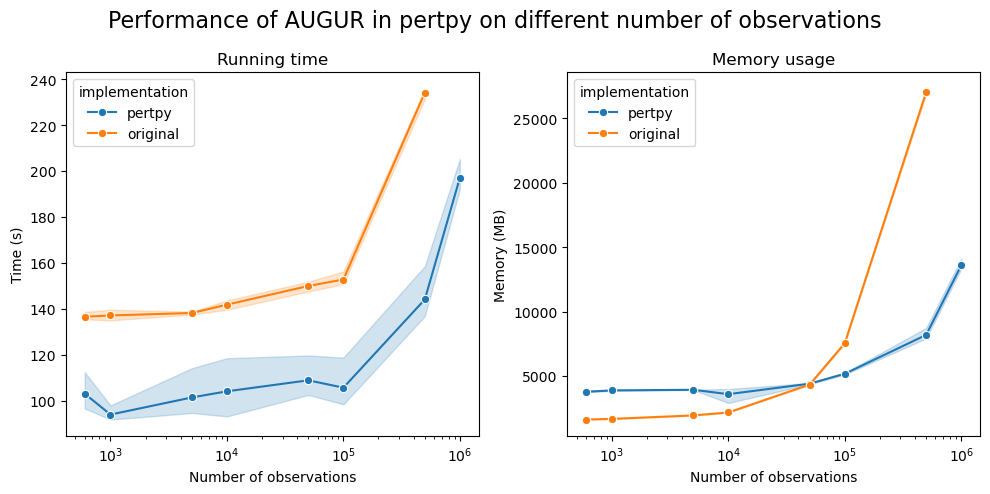

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
sns.lineplot(data=df, x='n_obs', y='s', ax=ax, marker='o', hue='implementation')
ax.set_xlabel('Number of observations')
ax.set_ylabel('Time (s)')
ax.set_title('Running time')
ax.set_xscale('log')

ax = axs[1]
sns.lineplot(data=df, x='n_obs', y='max_rss', ax=ax, marker='o', hue='implementation')
ax.set_xlabel('Number of observations')
ax.set_ylabel('Memory (MB)')
ax.set_title('Memory usage')
ax.set_xscale('log')
plt.suptitle('Performance of AUGUR in pertpy on different number of observations', fontsize=16)
plt.tight_layout()
plt.show()

## Augur results

In [3]:
auc_results = pd.read_csv("results/augur_0_r.csv", index_col=0)  # R
summary_metrics = pd.read_csv("results/augur_0_py.csv", index_col=0)  # pertpy


[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1        0.11111111 0.12222222
 0.13333333 0.14444444 0.15555556 0.16666667 0.17777778 0.18888889
 0.2        0.21111111 0.22222222 0.23333333 0.24444444 0.25555556
 0.26666667 0.27777778 0.28888889 0.3        0.31111111 0.32222222
 0.33333333 0.34444444 0.35555556 0.36666667 0.37777778 0.38888889
 0.4        0.41111111 0.42222222 0.43333333 0.44444444 0.45555556
 0.46666667 0.47777778 0.48888889 0.5        0.51111111 0.52222222
 0.53333333 0.54444444 0.55555556 0.56666667 0.57777778 0.58888889
 0.6        0.61111111 0.62222222 0.63333333 0.64444444 0.65555556
 0.66666667 0.67777778 0.68888889 0.7        0.71111111 0.72222222
 0.73333333 0.74444444 0.75555556 0.76666667 0.77777778 0.78888889
 0.8        0.81111111 0.82222222 0.83333333 0.84444444 0.85555556
 0.86666667 0.87777778 0.88888889 0.9        0.91111111 0.92222222
 0.93333333 0.94444444 0.95555556 0.96666667 0.97777778 0.9888

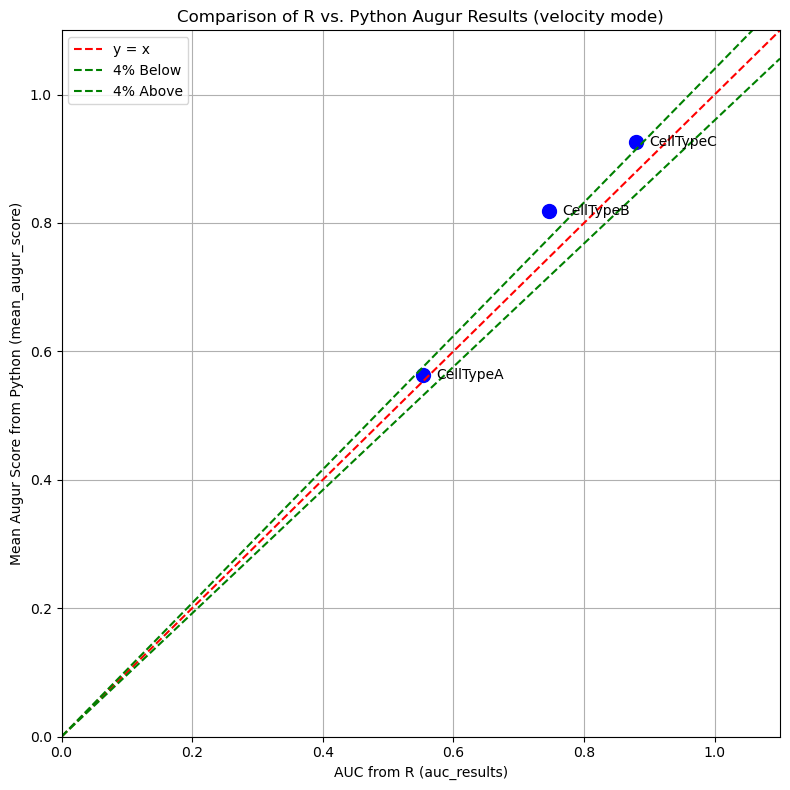

In [4]:
# 3. Extract Python mean_augur_score
py_scores = summary_metrics.loc["mean_augur_score"]  # row is "mean_augur_score"
py_scores_df = py_scores.reset_index()
py_scores_df.columns = ["cell_type", "python_score"]

# 4. Merge with R results by cell_type
merged_df = pd.merge(auc_results, py_scores_df, on="cell_type")

# 5. Plot the points
plt.figure(figsize=(8, 8))

plt.scatter(merged_df["auc"], merged_df["python_score"], s=100, color="blue")

for _, row in merged_df.iterrows():
    plt.text(row["auc"] + 0.02, row["python_score"], row["cell_type"],
             fontsize=10, verticalalignment='center')

# 6. Plot lines: y = x, y = 0.96x, y = 1.04x
x_vals = np.linspace(0, 1.1, 100)
plt.plot(x_vals, x_vals, ls="--", c="red", label="y = x")             # Diagonal
plt.plot(x_vals, 0.96 * x_vals, ls="--", c="green", label="4% Below") # 96% line
plt.plot(x_vals, 1.04 * x_vals, ls="--", c="green", label="4% Above") # 104% line

print(x_vals)
print(x_vals*0.96)
print(x_vals*1.04)

# 7. Adjust axis limits
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.xlabel("AUC from R (auc_results)")
plt.ylabel("Mean Augur Score from Python (mean_augur_score)")
plt.title("Comparison of R vs. Python Augur Results (velocity mode)")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
